In [2]:
import pandas as pd
df = pd.read_csv('cleaned_data_onlyqcut.csv')
df

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.047619,3,6,1,6,1.0,0.0,0.0,1.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.024390,2,6,3,6,0.0,0.0,1.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1,0.190476,1,6,5,6,1.0,0.0,0.0,1.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,0,0.025641,5,5,1,5,1.0,0.0,0.0,1.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.046512,6,6,4,4,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0.128205,6,5,2,5,1.0,0.0,0.0,0.0,1.0
9996,516,35,10,57369.61,1,1,1,101699.77,0,0.285714,1,3,2,6,1.0,0.0,0.0,0.0,1.0
9997,709,36,7,0.00,1,0,1,42085.58,1,0.194444,5,4,2,2,1.0,0.0,0.0,1.0,0.0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0.071429,6,6,3,5,0.0,1.0,0.0,0.0,1.0


In [3]:
x = df.drop(['churn'], axis = 1)
y = df['churn']

In [4]:
#Chia tập train, test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state= 42)

# Bước 4: Xây dựng mô hình

<sử dụng các mô hình có sẵn trong các thư viện như sklearn, xgboost, lightgbm,.. để thực train các mô hình dự báo. Sau đó sử dụng các metric để tính toán các chỉ số đánh giá mô hình: ví dụ như sử dụng
classification_report để đánh giá mô hình phân loại>

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [6]:
dict = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
#Model tuning: nói rõ các tham số cần tìm, cách thực hiện
grid = GridSearchCV(RandomForestClassifier(), dict, cv = 5)
grid.fit(x_train, y_train)
print(grid.best_params_)

{'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 30}


In [7]:
grid_params = grid.best_params_

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.46      0.57       393

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000



<Axes: >

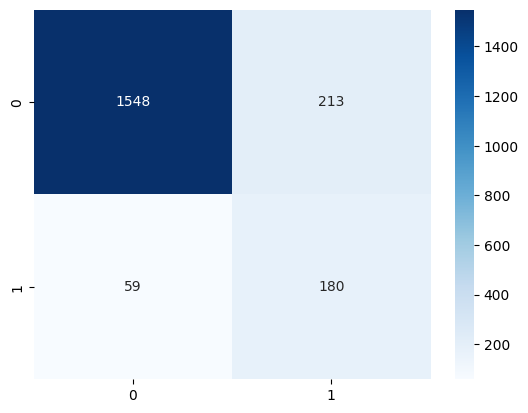

In [8]:
rf_grid = RandomForestClassifier(max_depth = grid_params['max_depth'], min_samples_leaf = grid_params['min_samples_leaf'], min_samples_split = grid_params['min_samples_split'], n_estimators = grid_params['n_estimators'])
rf_grid.fit(x_train, y_train)
y_pred = rf_grid.predict(x_test)
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(y_pred, y_test)
sns.heatmap(cf, annot = True, cmap = 'Blues', fmt = 'g')


# Bước 5: Tối ưu mô hình bằng cách xử lý mất cân bằng dữ liệu kết hợp với essemble learning

<Khi yêu cầu doanh nghiệp ưu tiên các chỉ số dự báo phải đi kèm với 1 mức độ rủi ro nào đó nhất định tùy nơi, chúng ta thường phải tối ưu lại dữ liệu tập train bằng cách sử dụng các thuật toán xử lý mất cân bằng dữ liệu nhưu SMOTE, Tomek Links, SMOTE + Tomek Links,... để tối ưu lại chỉ số mong muốn và sau đó sử dụng Catboost>

In [ ]:
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

# Apply SMOTE to balance the data
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Train CatBoost model using the balanced data
catboost = CatBoostClassifier(iterations=100, depth=grid_params['max_depth'], learning_rate=0.1, verbose=0)
catboost.fit(x_train_smote, y_train_smote)
y_pred = catboost.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1607
           1       0.62      0.59      0.61       393

    accuracy                           0.85      2000
   macro avg       0.76      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000



In [ ]:
from imblearn.under_sampling import TomekLinks

# Apply Tomek Links to balance the data
tomek = TomekLinks()
x_train_tomek, y_train_tomek = tomek.fit_resample(x_train, y_train)

# Train CatBoost model using the balanced data
catboost_tomek = CatBoostClassifier(iterations=100, depth=grid_params['max_depth'], learning_rate=0.1, verbose=0)
catboost_tomek.fit(x_train_tomek, y_train_tomek)
y_pred_tomek = catboost_tomek.predict(x_test)
print(classification_report(y_test, y_pred_tomek))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1607
           1       0.71      0.49      0.58       393

    accuracy                           0.86      2000
   macro avg       0.80      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



In [31]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN to balance the data
adasyn = ADASYN()
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train, y_train)

# Train CatBoost model using the balanced data
catboost_adasyn = CatBoostClassifier(iterations=100, depth=grid_params['max_depth'], learning_rate=0.1, verbose=0)
catboost_adasyn.fit(x_train_adasyn, y_train_adasyn)
y_pred_adasyn = catboost_adasyn.predict(x_test)
print(classification_report(y_test, y_pred_adasyn))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1607
           1       0.62      0.59      0.60       393

    accuracy                           0.85      2000
   macro avg       0.76      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000



In [32]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN to balance the data
smote_enn = SMOTEENN()
x_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(x_train, y_train)

# Train CatBoost model using the balanced data
catboost_smote_enn = CatBoostClassifier(iterations=100, depth=grid_params['max_depth'], learning_rate=0.1, verbose=0)
catboost_smote_enn.fit(x_train_smote_enn, y_train_smote_enn)
y_pred_smote_enn = catboost_smote_enn.predict(x_test)
print(classification_report(y_test, y_pred_smote_enn))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1607
           1       0.54      0.61      0.57       393

    accuracy                           0.82      2000
   macro avg       0.72      0.74      0.73      2000
weighted avg       0.83      0.82      0.83      2000



In [33]:
import pandas as pd
from sklearn.metrics import classification_report

# Extract classification reports
report_rf = classification_report(y_test, y_pred, output_dict=True)
report_catboost_smote = classification_report(y_test, y_pred, output_dict=True)
report_catboost_tomek = classification_report(y_test, y_pred_tomek, output_dict=True)
report_catboost_adasyn = classification_report(y_test, y_pred_adasyn, output_dict=True)
report_catboost_smote_enn = classification_report(y_test, y_pred_smote_enn, output_dict=True)

# Create a summary table
summary_table = pd.DataFrame({
    'Model': ['RandomForest', 'CatBoost_SMOTE', 'CatBoost_Tomek', 'CatBoost_ADASYN', 'CatBoost_SMOTEENN'],
    'Precision': [report_rf['weighted avg']['precision'], report_catboost_smote['weighted avg']['precision'], report_catboost_tomek['weighted avg']['precision'], report_catboost_adasyn['weighted avg']['precision'], report_catboost_smote_enn['weighted avg']['precision']],
    'Recall': [report_rf['weighted avg']['recall'], report_catboost_smote['weighted avg']['recall'], report_catboost_tomek['weighted avg']['recall'], report_catboost_adasyn['weighted avg']['recall'], report_catboost_smote_enn['weighted avg']['recall']],
    'F1-Score': [report_rf['weighted avg']['f1-score'], report_catboost_smote['weighted avg']['f1-score'], report_catboost_tomek['weighted avg']['f1-score'], report_catboost_adasyn['weighted avg']['f1-score'], report_catboost_smote_enn['weighted avg']['f1-score']]
})

print(summary_table)

               Model  Precision  Recall  F1-Score
0       RandomForest   0.845733  0.8480  0.846797
1     CatBoost_SMOTE   0.845733  0.8480  0.846797
2     CatBoost_Tomek   0.849931  0.8605  0.850339
3    CatBoost_ADASYN   0.845460  0.8480  0.846642
4  CatBoost_SMOTEENN   0.830915  0.8225  0.826190


# Explainability and SHAP Analysis

In [14]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
explainer = shap.Explainer(rf_grid)
shap_values = explainer(x_test)


In [16]:
shap_values_class_1 = shap_values[:, :, 1]

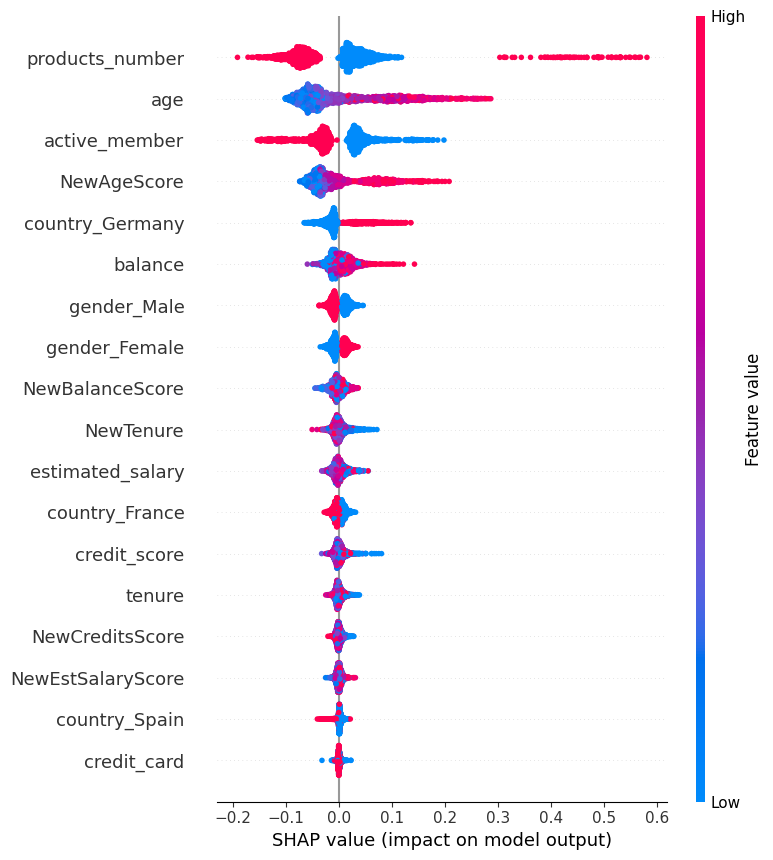

In [17]:
# Summary plot for the positive class
shap.summary_plot(shap_values_class_1, x_test, plot_type="dot", title="SHAP Summary Plot for Positive Class")


In [18]:
df.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'churn',
       'NewTenure', 'NewCreditsScore', 'NewAgeScore', 'NewBalanceScore',
       'NewEstSalaryScore', 'country_France', 'country_Germany',
       'country_Spain', 'gender_Female', 'gender_Male'],
      dtype='object')

In [19]:
df['products_number'].value_counts()

products_number
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

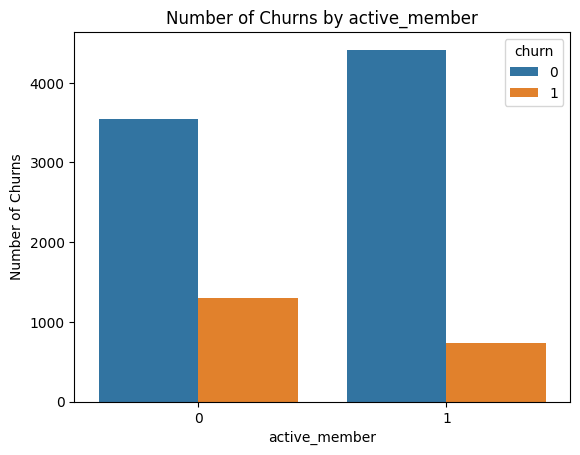

In [20]:
# Plot the data
sns.countplot(data=df, x='active_member', hue='churn')
plt.xlabel('active_member')
plt.ylabel('Number of Churns')
plt.title('Number of Churns by active_member')
plt.show()

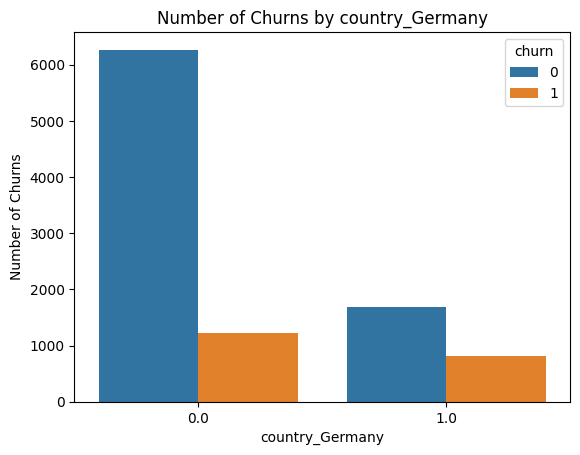

In [21]:
# Plot the data
sns.countplot(data=df, x='country_Germany', hue='churn')
plt.xlabel('country_Germany')
plt.ylabel('Number of Churns')
plt.title('Number of Churns by country_Germany')
plt.show()

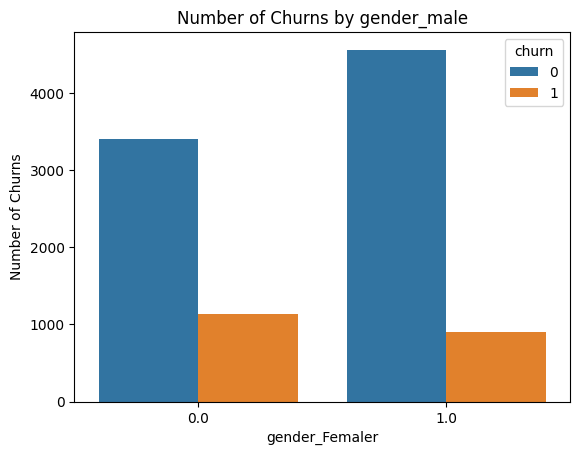

In [22]:
# Plot the data
sns.countplot(data=df, x='gender_Male', hue='churn')
plt.xlabel('gender_Femaler')
plt.ylabel('Number of Churns')
plt.title('Number of Churns by gender_male')
plt.show()

In [23]:
df['gender_Female'].value_counts()  

gender_Female
0.0    5457
1.0    4543
Name: count, dtype: int64

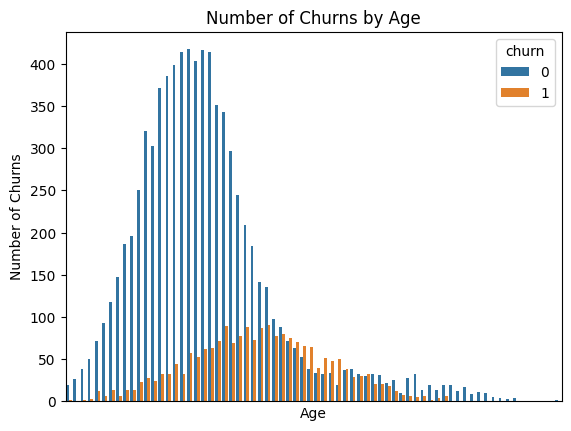

In [24]:
# Plot the data
sns.countplot(data=df, x='age', hue='churn')
plt.xlabel('Age')
plt.ylabel('Number of Churns')
plt.title('Number of Churns by Age')
plt.xticks(ticks=[])
plt.show()


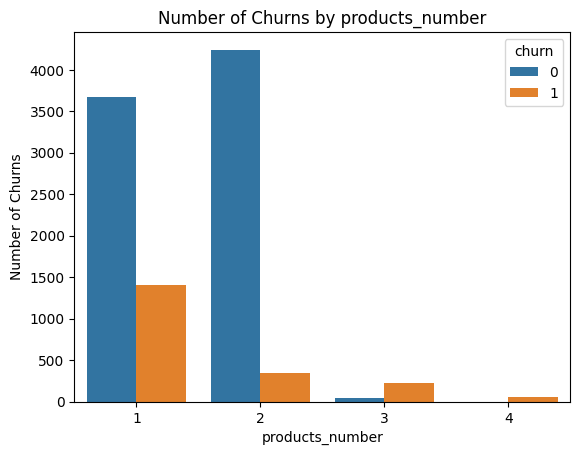

In [25]:
# Plot the data
sns.countplot(data=df, x='products_number', hue='churn')
plt.xlabel('products_number')
plt.ylabel('Number of Churns')
plt.title('Number of Churns by products_number')
plt.show()

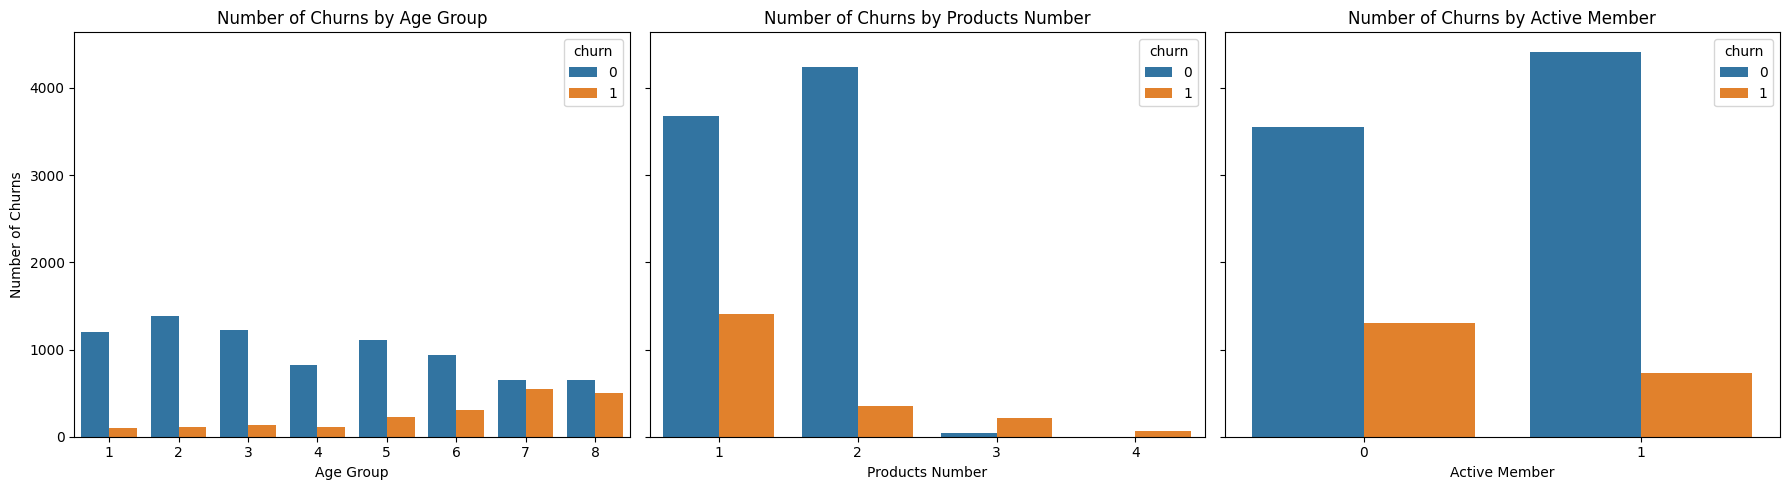

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo figure với 3 subplot trên 1 hàng
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Biểu đồ đầu tiên: Số lượng churns theo tuổi
sns.countplot(data=df, x='NewAgeScore', hue='churn', ax=axes[0])
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Number of Churns')
axes[0].set_title('Number of Churns by Age Group')

# Biểu đồ thứ hai: Số lượng churns theo số sản phẩm
sns.countplot(data=df, x='products_number', hue='churn', ax=axes[1])
axes[1].set_xlabel('Products Number')
axes[1].set_title('Number of Churns by Products Number')

# Biểu đồ thứ ba: Số lượng churns theo trạng thái thành viên hoạt động
sns.countplot(data=df, x='active_member', hue='churn', ax=axes[2])
axes[2].set_xlabel('Active Member')
axes[2].set_title('Number of Churns by Active Member')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [27]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=x_train.values,
    feature_names=x_train.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

# Explain a single prediction
i = 8  # Index of the instance to explain
exp = explainer.explain_instance(x_test.values[i], rf_grid.predict_proba, num_features=20)
exp.show_in_notebook(show_table=True, show_all=True)


c:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [28]:
x_test.head(10)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,country_France,country_Germany,country_Spain,gender_Female,gender_Male
6252,596,32,3,96709.07,2,0,0,41788.37000,0.093750,2,2,3,2,0.0,1.0,0.0,0.0,1.0
4684,623,43,1,0.00,2,1,1,146379.30000,0.023256,3,6,1,8,1.0,0.0,0.0,0.0,1.0
1731,601,44,4,0.00,2,1,0,58561.31000,0.090909,2,6,1,3,0.0,0.0,1.0,1.0,0.0
4742,506,59,8,119152.10,2,1,1,170679.74000,0.135593,1,8,4,9,0.0,1.0,0.0,0.0,1.0
4521,560,27,7,124995.98,1,1,1,114669.79000,0.259259,2,1,4,6,0.0,0.0,1.0,1.0,0.0
6340,790,37,8,0.00,2,1,1,149418.41000,0.216216,6,4,2,8,0.0,0.0,1.0,0.0,1.0
576,439,32,3,138901.61,1,1,0,75685.97000,0.093750,1,2,5,4,0.0,0.0,1.0,1.0,0.0
5202,597,22,6,101528.61,1,1,0,98597.40875,0.272727,2,1,3,5,0.0,1.0,0.0,1.0,0.0
6363,678,40,4,113794.22,1,1,0,16618.76000,0.100000,4,5,4,1,0.0,0.0,1.0,1.0,0.0
439,464,42,3,85679.25,1,1,1,164104.74000,0.071429,1,6,3,9,0.0,1.0,0.0,1.0,0.0


In [29]:
y_test.head(10)

6252    0
4684    0
1731    0
4742    0
4521    0
6340    0
576     0
5202    1
6363    0
439     0
Name: churn, dtype: int64